In [10]:
import sys
sys.path.append("../../")
from src.basenet import BaseNetDatabase, BaseNetCompiler, BaseNetModel
from tensorflow import keras
from IPython.display import display, Image

# BaseNetModel

## Advanced use tutorial

In this JuPyter Notebook we will learn further uses and specifications of the ``BaseNetModel`` Class.

### Contents

1. About ``BaseNetModel``.
2. Building a ``BaseNetModel``.
    1. Build from ``keras`` models.
    2. Build from ``BaseNetCompiler``.
    3. Load and save models.
3. Visualize your model.
4. Linking ``BaseNetDatabase`` to ``BaseNetModel``.
5. Fitting a ``BaseNetModel``.
6. Obtaining the ``BaseNetModel`` performance.
7. Using ``BaseNetModel`` in production.

8. Avoiding ThreadLocking in training (limited).
9. Acessing ``BaseNetResults``.


## 1. About BaseNetModel.

The BaseNetModel class provides a wrapper for the tf.keras.model API with easier use. When initialized,
it initializes a breech of databases in its attribute 'breech'. If we provide a compiler, the model will be
built from the compiler; however, if we provide a tf.keras.model, the compiler is ignored and the model is built
from the provided tf.keras.model.

To add a database to the model, we can use the method ``BaseNetModel.add_database()`` that takes a BaseNetDatabase as
input.

The class contains load and save methods to store the compilers (``.cpl`` files) and models (``.h5`` files) in the same
directory.

We also provide a ``BaseNetModel.fit()`` method that can create a separate process for training. The original framework
does not include this feature:

*   The ``BaseNetModel.fit()`` method takes as input the index of the loaded database via
``BaseNetModel.add_database()`` method and takes the train and validation subsets to fit the model.
*   If the training process should not block the main process, the parameters 'avoid_lock' must be set to True,
in that case, another process will take over the fitting tf.keras.model.fit() method and the information will
be updated in the return class: BaseNetResults.
*   In case we avoid the main process to be locked with the 'avoid_lock' feature, we will need to recover the
tf.keras.model with the ``BaseNetModel.recover()`` method once the training is finished (check
``BaseNetResults.is_training``).

We can also evaluate the performance of the database with the BaseNetModel.evaluate() method, that makes use of the
test subset.

We can also predict the output of a certain input with the BaseNetModel.predict() method.

We can also visualize the model with the ``BaseNetModel.print()`` method in a PNG image.

The following attributes can be found in a regular ``BaseNetModel``:

* :compiler:: It is the given compiler (BaseNetCompiler).
* :is_valid:: Tells if a model is valid or not (bool).
* :is_compiled:: Tells if a model is compiled or not (bool).
* :name:: The name of the model (str).
* :breech:: The list of the loaded databases (list[BaseNetDatabase]).
* :model:: It is the compiled keras model (tf.keras.model).
* :summary:: The tf.keras.model information (str).
    
## 2. Building a BaseNetModel.

    BaseNetModel(self, 
                 compiler=None, 
                 model: keras.Model = None, 
                 name: str = '', 
                 verbose: bool = False):

    The BaseNetModel implements an API that makes use of keras and tensorflow to build Deep Learning Models.
    :param compiler: BaseNetCompiler object to build the model.
    :param model: If a keras.model is already compiled, you can import it in the model parameter, so the compiler won't be used during the construction.
    :param name: The name of the model.
    :param verbose: Shows relevant information for debugging pruposes.


In [2]:
def __init__(self, compiler=None, model: keras.Model = None, name: str = '', verbose: bool = False):
    [...]

Providing a ``BaseNetCompiler`` is the proper way to build a ``BaseNetModel``, it will store all the relevant information of the Model. However, if we decide to build a ``BaseNetModel`` from a
``Keras`` model, we will miss some relevant information.

### 2.1. Build from ``Keras`` models.

You can build a ``BaseNetModel`` with a ``Keras`` model. Let's build a MLP in the Keras API:

In [3]:
model = keras.Sequential(
    [
        keras.layers.Input(256),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(1)
    ]
)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                2570      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


Now, we build the ``BaseNetModel`` from the ``Keras`` model:

In [4]:
bnm = BaseNetModel(model=model)
bnm

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                2570      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


Model object with the following parameters:
Compiler: None
Summary: None

Note that there is no compiler linked to the model. As there is no ``BaseNetCompiler`` linked to it. However, all the other features are included in this model.

### 2.1. Build from ``BaseNetCompiler``.

The easiest way to build the model is to use a ``BaseNetCompiler`` using a ``YAML`` file with all the model specification. You should look first at the ``BaseNetCompiler`` advanced tutorial.

In [5]:
yaml_path = './compilers/example2.yaml'
bnm = BaseNetCompiler.build_from_yaml(yaml_path).compile()
bnm

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model object with the following parameters:
Compiler: Compiler with 1 layers, options:
{'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
Summary: Model: "model_in_serie"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                352       
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 682
Trainable params: 682
Non-trainable params: 0
_________________________________________________________________

It only will take a line of code, but several lines in the ``YAML`` file. This way it is very easy to compile models from one workspace to another and share your model with other co-workers.

### 2.3. Save and load models.

You can load a ``BaseNetModel`` with the ``BaseNetModel.load()`` method and save it with the ``BaseNetModel.save()`` method:

In [6]:
@staticmethod
def load(model_path: str, compiler_path: str = ''):
    """
    This function loads a pair: .cpl (BaseNetCompiler) and .h5 (keras.model) format and builds a BaseNetModel from
    the loaded parameters.
    :param model_path: Path where the keras.model is being loaded from the file system.
    :param compiler_path: Path where the BaseNetCompiler is being loaded from the file system.
    :return: The BaseNetModel with the given model path.
    """

def save(self, model_path: str, compiler_path: str = '') -> bool:
    """
    This function saves the BaseNetModel in a pair: .cpl (BaseNetCompiler) and .h5 (keras.model) format.
    :param model_path: Path where the keras.model is being saved in the file system.
    :param compiler_path: Path where the BaseNetCompiler is being saved in the file system.
    :return: True if the saving was successful. False if not.
    """

If you provide the ``model_path`` it will automatically look for the compiler with the same name in the same directory. If you provide a ``compiler_path`` it will look for the compiler there. Normally, you want to keep both files together (in the same directory), so it will be managed automatically and only provide the ``model_path`` route.

Let's load and save the current model:

In [7]:
model_path = './models/test_model.h5'
bnm.save(model_path)
bnm2 = BaseNetModel.load(model_path)
bnm2

Model: "model_in_serie"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_13 (Dense)            (None, 32)                352       
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 682
Trainable params: 682
Non-trainable params: 0
_________________________________________________________________


Model object with the following parameters:
Compiler: Compiler with 1 layers, options:
{'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
Summary: None

## 3. Visualize your model.

You can visualize your model calling the ```.print()``` method. The method takes an argument with the **directory** path where a ``PNG`` image will be stored. 

Model stored as ./other/test_model.png:



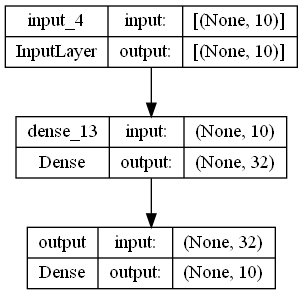

In [14]:
image_path = './other'
bnm2.print(image_path)
print(f'Model stored as {image_path}/{bnm2.name}.png:\n')
Image(f"{image_path}/{bnm2.name}.png")

## 4. Linking ``BaseNetDatabase`` to ``BaseNetModel``.

You must link a BaseNetDatabase to a model in order to make the Database available to the model.


4. Fitting a ``BaseNetModel``.
5. Obtaining the ``BaseNetModel`` performance.
6. Using ``BaseNetModel`` in production.

7. Avoiding ThreadLocking in training (limited).
8. Acessing ``BaseNetResults``.